**Comfortable reading and full navigation (recommended)**  
> Web report (HTML): https://crgalleguillos.github.io/chile-night-lights-change/  
>
> Note: GitHub may not reliably support internal navigation inside `.ipynb` files.  
> The web report is intended as the primary reading version.

# Chile Night Lights Change (VIIRS) — 2014 vs 2019 vs 2024

**Author**: Cristián Andrés Galleguillos Vega  
**Objective**: Quantify and visualize changes in nighttime lights across Chile using **VIIRS Black Marble**, comparing **2014, 2019, 2024**, and aggregating results by administrative regions.  
**Outputs**: annual mean rasters, deltas, categorical change maps, and regional metrics tables.


## Notebook map

1. [Context and objective](#context-and-objective)  
2. [Data sources](#data-sources)  
3. [Project setup](#project-setup)  
4. [Annual mean composites (HDF5 → annual mean raster)](#annual-mean-composites)  
5. [Georeferencing strategy (BBox-based fallback)](#georeferencing-strategy)  
6. [Clipping to Chile boundary](#clipping-to-chile)  
7. [Normalization (Min–Max per year)](#normalization)  
8. [Change detection (deltas) + summary statistics](#change-detection)  
9. [Categorical change maps](#categorical-change-maps)  
10. [Regional aggregation and metrics](#regional-aggregation)  
11. [Results and interpretation](#results-and-interpretation)  
12. [Limitations and next steps](#limitations-and-next-steps)  
13. [Credits and technologies](#credits-and-technologies)  
14. [Project structure](#project-structure)  
15. [Final reflection](#final-reflection)

<a id="context-and-objective"></a>
## 1. Context and objective

Nighttime lights (NTL) are widely used as a proxy for **human activity**, **urbanization**, and **economic development**.  
This notebook analyzes spatial changes in NTL across **Chile** using the **VIIRS Black Marble** product.

**Main goals**
- Build annual mean NTL rasters for **2014**, **2019**, and **2024**
- Compare years using consistent visualization and normalization
- Compute **change rasters** (2019–2014, 2024–2019)
- Produce **categorical change maps** (increase / decrease / stable)
- Aggregate change metrics by **administrative regions**

<a id="data-sources"></a>
## 2. Data sources

**Primary dataset**
- VIIRS Black Marble (annual composites derived from monthly HDF5)

**Geospatial boundaries**
- Chile national boundary (for clipping)
- Chile administrative regions (for aggregation)

**Assumptions**
- Annual mean is computed from the set of monthly composites available per year
- Radiance values are comparable after standard preprocessing and normalization

<a id="project-setup"></a>
## 3. Project setup

### 3.1 Environment and libraries
- Geospatial: `geopandas`, `rioxarray`, `rasterio`
- Arrays: `numpy`, `xarray`
- Visualization: `matplotlib`
- Utilities: `pathlib`, `warnings`

### 3.2 Reproducibility
- Central configuration via `src/config.py` (paths, years)
- Output folders:
  - `processed/annual_means/`
  - `processed/clipped/`
  - `processed/normalized/`
  - `processed/deltas/`
  - `processed/categorical/`
  - `processed/tables/`


### Environment setup and repository initialization

In [1]:
import sys
from pathlib import Path
import warnings

# Suppress common runtime warnings from geospatial stack
warnings.filterwarnings("ignore", category=RuntimeWarning)

# Resolve repository root (assumes notebook is located in repo/notebooks/)
ROOT = Path.cwd().resolve().parents[0]

# Ensure repository root is in Python path for src/ imports
if str(ROOT) not in sys.path:
    sys.path.insert(0, str(ROOT))

# Validate expected project structure
assert (ROOT / "src").exists(), "src/ directory not found. Check repository structure."

from src.utils import suppress_warnings, set_working_directory_to_repo_root

# Apply project-wide warning suppression and reset CWD to repo root
suppress_warnings()
_ = set_working_directory_to_repo_root()

### Environment imports and global settings

In [34]:
import matplotlib.pyplot as plt
import rioxarray as rxr
import numpy as np
import xarray as xr
import urllib.request
import fiona
import geopandas as gpd
import pandas as pd

from src.config import YEARS, BBOX_CHILE, RAW_DIR, PROC_DIR
from src.download import login_earthaccess, download_year_vnp46a3
from src.blackmarble import annual_mean_ntl
from src.geoprocessing import georef_raster_with_bbox, clip_raster_to_geometry
from src.boundaries import load_chile_boundary
from src.geo_utils import minmax_normalize
from matplotlib.colors import ListedColormap, BoundaryNorm
from pathlib import Path

In [3]:
# Authenticate with Earthdata for VIIRS data access

auth = login_earthaccess()

Enter your Earthdata Login username:  crgalleguillos
Enter your Earthdata password:  ········


In [ ]:
import matplotlib.pyplot as plt
import rioxarray as rxr

from src.config import YEARS, BBOX_CHILE, RAW_DIR, PROC_DIR
from src.download import login_earthaccess, download_year_vnp46a3
from src.blackmarble import annual_mean_ntl
from src.geoprocessing import georef_raster_with_bbox, clip_raster_to_geometry
from src.boundaries import load_chile_boundary

<a id="annual-mean-composites"></a>
## 4. Annual mean composites (HDF5 → annual mean raster)

### What
Convert monthly VIIRS HDF5 layers into **annual mean** rasters and export to GeoTIFF.

### Why
Annual means reduce month-to-month variability and provide a stable baseline for inter-annual comparison.

### How
- Load monthly datasets per year
- Compute per-pixel mean (handling nodata)
- Export annual mean raster (raw)

In [4]:
# Download VIIRS Black Marble (VNP46A3) granules for each study year
# This step ensures all required HDF5 inputs are available locally before processing.

for year in YEARS:
    download_year_vnp46a3(
        year=year,
        bbox=BBOX_CHILE,
        raw_dir=RAW_DIR
    )

2014: 260 granules found
Already downloaded: 130 files in C:\Users\crgal\Desktop\Github\chile-night-lights-change\data\raw\blackmarble\2014
2014: 130 files downloaded
2019: 260 granules found
Already downloaded: 130 files in C:\Users\crgal\Desktop\Github\chile-night-lights-change\data\raw\blackmarble\2019
2019: 130 files downloaded
2024: 260 granules found
Already downloaded: 130 files in C:\Users\crgal\Desktop\Github\chile-night-lights-change\data\raw\blackmarble\2024
2024: 130 files downloaded


We first download the VNP46A3 granules for each year and then compute annual mean composites from the downloaded HDF5 files.

Download logs are shown for transparency. If files already exist locally, the function will skip re-downloading.

In [5]:
# Compute annual mean nighttime lights (per-pixel mean) from downloaded HDF5 granules
# A quality mask is applied when available to reduce low-quality observations.

annual_raw = {}

for year in YEARS:
    h5_dir = RAW_DIR / "blackmarble" / str(year)
    h5_files = sorted(h5_dir.glob("*.h5"))

    assert len(h5_files) > 0, f"No HDF5 files found for {year} in: {h5_dir}"
    print(f"{year}: {len(h5_files)} H5 files")

    annual_raw[year] = annual_mean_ntl(h5_files, use_quality_mask=True)

2014: 130 H5 files


Reading NTL granules: 100%|██████████| 130/130 [00:27<00:00,  4.79it/s]


2019: 130 H5 files


Reading NTL granules: 100%|██████████| 130/130 [00:27<00:00,  4.79it/s]


2024: 130 H5 files


Reading NTL granules: 100%|██████████| 130/130 [00:27<00:00,  4.71it/s]


In [6]:
# Create output directory for annual mean rasters (raw)

out_dir = PROC_DIR / "rasters"
out_dir.mkdir(parents=True, exist_ok=True)
out_dir

WindowsPath('C:/Users/crgal/Desktop/Github/chile-night-lights-change/data/processed/rasters')

In [7]:
# Export annual mean rasters to GeoTIFF (raw composites)

out_raw = {y: (out_dir / f"viirs_{y}_annual_mean_raw.tif") for y in YEARS}

for y in YEARS:
    annual_raw[y].rio.to_raster(out_raw[y], dtype="float32")
    print("Saved:", out_raw[y])

Saved: C:\Users\crgal\Desktop\Github\chile-night-lights-change\data\processed\rasters\viirs_2014_annual_mean_raw.tif
Saved: C:\Users\crgal\Desktop\Github\chile-night-lights-change\data\processed\rasters\viirs_2019_annual_mean_raw.tif
Saved: C:\Users\crgal\Desktop\Github\chile-night-lights-change\data\processed\rasters\viirs_2024_annual_mean_raw.tif


**Each annual raster represents the per-pixel mean night-time light intensity computed from all available VIIRS Black Marble observations within that year, rather than a single snapshot in time.**

<a id="georeferencing-strategy"></a>
## 5. Georeferencing strategy (BBox-based fallback)

### Problem
Some rasters may not carry full georeferencing metadata.

### Strategy
Use a **BBox-based fallback** to enforce consistent spatial referencing when needed, then validate visually.

### Validation
- Quick plot overlays with Chile boundary
- Confirm alignment and expected extent

The annual mean rasters derived from HDF5 subdatasets do not contain
explicit spatial coordinates. To enable spatial operations, we assign
longitude and latitude coordinates using the Chile bounding box as a
fallback georeferencing strategy.

In [8]:
# Assign WGS84 georeferencing using Chile BBOX (fallback strategy) and export GeoTIFFs

raw_dir = PROC_DIR / "rasters"
geo_dir = PROC_DIR / "rasters_georef"
geo_dir.mkdir(parents=True, exist_ok=True)

georef_paths = {}

for y in YEARS:
    in_raster = raw_dir / f"viirs_{y}_annual_mean_raw.tif"
    out_raster = geo_dir / f"viirs_{y}_annual_mean_wgs84.tif"

    georef_raster_with_bbox(
        in_path=in_raster,
        out_path=out_raster,
        bbox=BBOX_CHILE,
        crs="EPSG:4326",
    )

    georef_paths[y] = out_raster
    print("Georeferenced:", out_raster)

Georeferenced: C:\Users\crgal\Desktop\Github\chile-night-lights-change\data\processed\rasters_georef\viirs_2014_annual_mean_wgs84.tif
Georeferenced: C:\Users\crgal\Desktop\Github\chile-night-lights-change\data\processed\rasters_georef\viirs_2019_annual_mean_wgs84.tif
Georeferenced: C:\Users\crgal\Desktop\Github\chile-night-lights-change\data\processed\rasters_georef\viirs_2024_annual_mean_wgs84.tif


### Visual verification

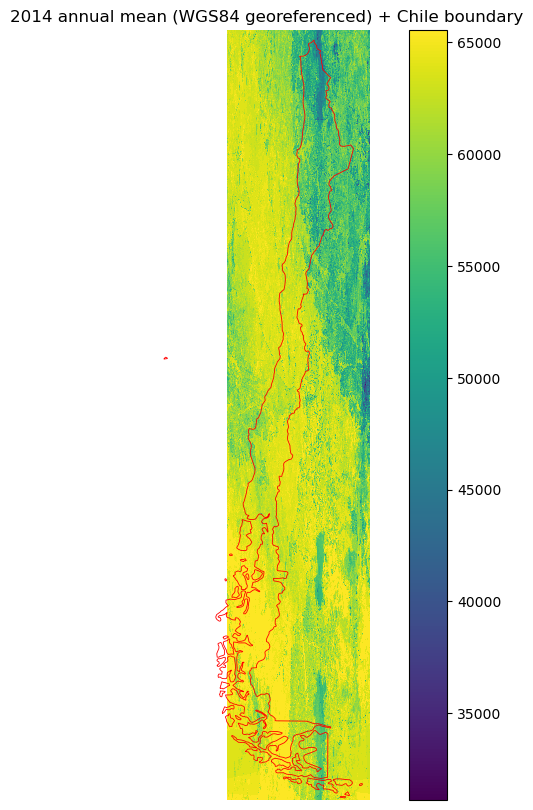

In [9]:
# Visual sanity check: overlay Chile boundary on the georeferenced raster (example: 2014)

chile = load_chile_boundary(PROC_DIR / "chile_boundary.gpkg")

da = rxr.open_rasterio(georef_paths[2014]).squeeze()

fig, ax = plt.subplots(figsize=(6, 10))
da.plot.imshow(ax=ax)
chile.boundary.plot(ax=ax, edgecolor="red", linewidth=0.6)

ax.set_title("2014 annual mean (WGS84 georeferenced) + Chile boundary")
ax.set_xlim(-80, -65)
ax.set_ylim(-56, -17)
ax.set_axis_off()
plt.show()

Visual sanity check confirms correct spatial alignment between the georeferenced raster and Chile’s national boundary.

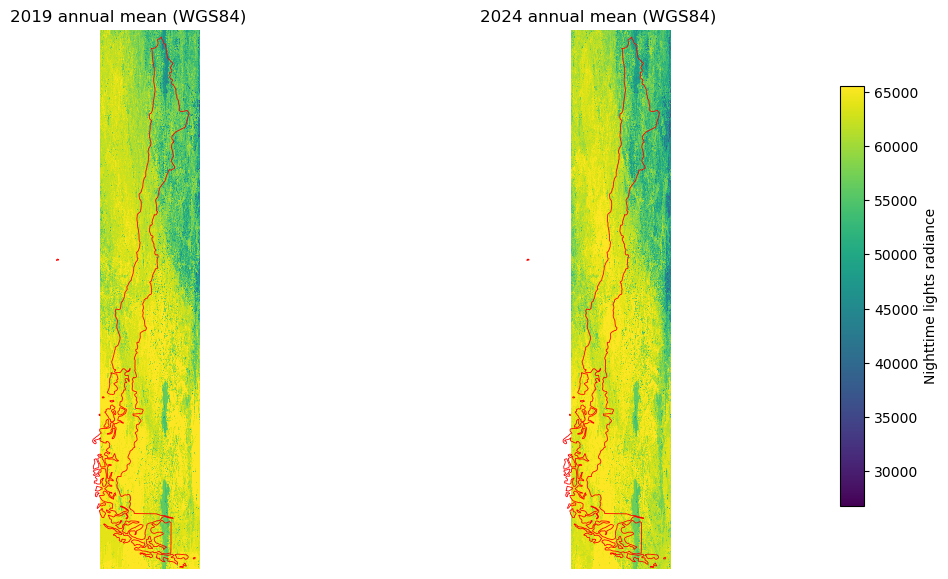

In [10]:
# Visual sanity check: georeferenced annual means (2019 vs 2024) with shared colorbar

fig, axes = plt.subplots(
    ncols=2,
    figsize=(12, 7),
    sharex=True,
    sharey=True
)

# Leave room on the right for a dedicated colorbar axis
fig.subplots_adjust(wspace=0.08, right=0.88)

images = []

for ax, year in zip(axes, [2019, 2024]):
    da = rxr.open_rasterio(georef_paths[year]).squeeze()

    img = da.plot.imshow(ax=ax, add_colorbar=False)
    images.append(img)

    chile.boundary.plot(ax=ax, edgecolor="red", linewidth=0.6)
    ax.set_title(f"{year} annual mean (WGS84)")
    ax.set_xlim(-80, -65)
    ax.set_ylim(-56, -17)
    ax.set_axis_off()

# Add a dedicated axis for the colorbar: [left, bottom, width, height] in figure coordinates
cax = fig.add_axes([0.90, 0.20, 0.02, 0.60])
cbar = fig.colorbar(images[0], cax=cax)
cbar.set_label("Nighttime lights radiance")

plt.show()

Visual inspection indicates correct spatial alignment and consistent radiance scaling for both years.

<a id="clipping-to-chile"></a>
## 6. Clipping to Chile boundary

### What
Clip annual rasters to Chile’s boundary to remove ocean/irrelevant areas.

### Why
Improves interpretability and ensures change metrics reflect only Chilean territory.

### How
- Reproject boundary if required
- Clip rasters using `rio.clip()`
- Export clipped rasters

### Clip georeferenced annual rasters to Chile boundary

In [11]:
geo_dir = PROC_DIR / "rasters_georef"
clip_dir = PROC_DIR / "rasters_clipped"
clip_dir.mkdir(parents=True, exist_ok=True)

clipped_paths = {}

for year in YEARS:
    in_raster = geo_dir / f"viirs_{year}_annual_mean_wgs84.tif"
    out_raster = clip_dir / f"viirs_{year}_annual_mean_clip.tif"

    # Defensive check: ensure expected input exists
    assert in_raster.exists(), f"Input raster not found: {in_raster}"

    clip_raster_to_geometry(
        in_path=in_raster,
        out_path=out_raster,
        geometry=chile,
        raster_crs_fallback="EPSG:4326",
    )

    clipped_paths[y] = out_raster
    print("Clipped:", out_raster)

Clipped: C:\Users\crgal\Desktop\Github\chile-night-lights-change\data\processed\rasters_clipped\viirs_2014_annual_mean_clip.tif
Clipped: C:\Users\crgal\Desktop\Github\chile-night-lights-change\data\processed\rasters_clipped\viirs_2019_annual_mean_clip.tif
Clipped: C:\Users\crgal\Desktop\Github\chile-night-lights-change\data\processed\rasters_clipped\viirs_2024_annual_mean_clip.tif


Clipped rasters define a consistent spatial domain for all subsequent normalization and change analyses.

<a id="normalization"></a>
## 7. Normalization (Min–Max per year)

### What
Normalize each year to a 0–1 scale using Min–Max.

### Why
Makes maps visually comparable and reduces scale dominance when computing deltas.

### How
- Min–Max per raster (year)
- Export normalized rasters
- Plot 2014–2019–2024 using the same color scale


### Normalize the 3 cropped rasters

In [16]:
# Min–Max normalize clipped rasters (per year) and export GeoTIFFs

clip_dir = PROC_DIR / "rasters_clipped"
norm_dir = PROC_DIR / "rasters_norm"
norm_dir.mkdir(parents=True, exist_ok=True)

norm_paths = {}  # reset to avoid partial state

for year in YEARS:
    in_raster = clip_dir / f"viirs_{year}_annual_mean_clip.tif"
    out_raster = norm_dir / f"viirs_{year}_norm.tif"

    assert in_raster.exists(), f"Input raster not found: {in_raster}"

    minmax_normalize(in_raster, out_raster)
    norm_paths[year] = out_raster
    print("Normalized:", out_raster)

Normalized: C:\Users\crgal\Desktop\Github\chile-night-lights-change\data\processed\rasters_norm\viirs_2014_norm.tif
Normalized: C:\Users\crgal\Desktop\Github\chile-night-lights-change\data\processed\rasters_norm\viirs_2019_norm.tif
Normalized: C:\Users\crgal\Desktop\Github\chile-night-lights-change\data\processed\rasters_norm\viirs_2024_norm.tif


In [17]:
print("norm_paths keys:", list(norm_paths.keys()))

norm_paths keys: [2014, 2019, 2024]


### Comparative maps 2014–2019–2024 (same scale)

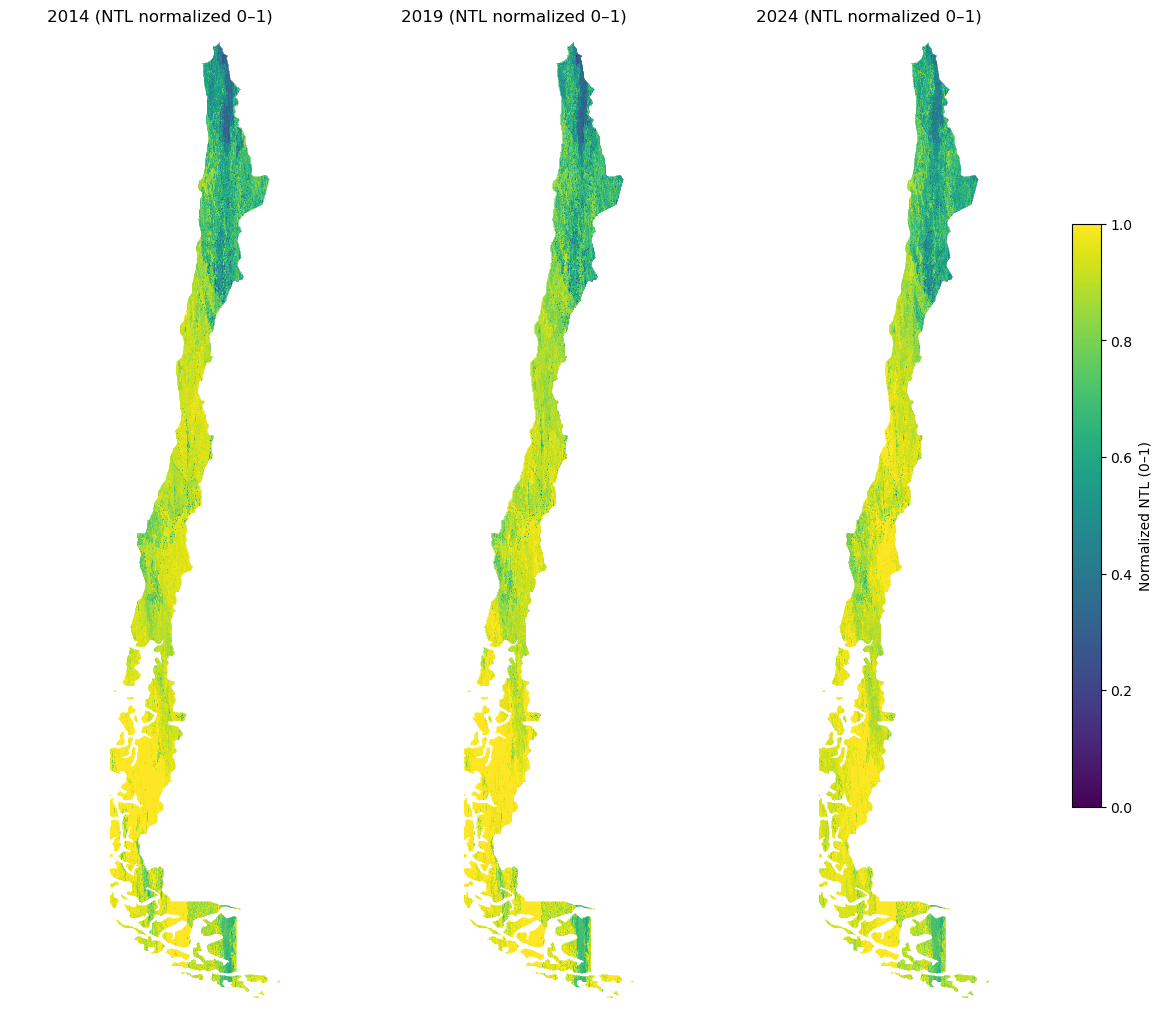

In [18]:
# Comparative maps (2014–2019–2024) using the same 0–1 color scale

das = {y: rxr.open_rasterio(norm_paths[y]).squeeze() for y in YEARS}

fig, axes = plt.subplots(1, 3, figsize=(12, 10), constrained_layout=True)
vmin, vmax = 0.0, 1.0
im = None

for ax, y in zip(axes, YEARS):
    im = das[y].plot.imshow(ax=ax, vmin=vmin, vmax=vmax, add_colorbar=False)
    chile.boundary.plot(ax=ax, edgecolor="white", linewidth=0.3)
    ax.set_title(f"{y} (NTL normalized 0–1)")
    ax.set_xlim(-80, -65)
    ax.set_ylim(-56, -17)
    ax.set_axis_off()

cbar = fig.colorbar(im, ax=axes.ravel().tolist(), shrink=0.6)
cbar.set_label("Normalized NTL (0–1)")
plt.show()

**Note: Min–Max is applied independently per year. Values represent relative intensity within each year (0–1), not absolute radiance comparability across years.**

<a id="change-detection"></a>
## 8. Change detection (deltas) + summary statistics

### What
Compute:
- **Δ(2019–2014)**
- **Δ(2024–2019)**

### Why
Deltas provide a direct spatial estimate of increasing/decreasing night activity.

### How
- Align rasters to a reference grid (reproject-match)
- Subtract normalized rasters
- Save delta GeoTIFFs
- Summary stats + histograms

**Note: Because deltas are computed from per-year normalized rasters, values represent relative changes in spatial intensity rather than absolute radiance differences**

### Load and align normalized rasters (common grid)

In [20]:
da14 = rxr.open_rasterio(norm_paths[2014]).squeeze()
da19 = rxr.open_rasterio(norm_paths[2019]).squeeze()
da24 = rxr.open_rasterio(norm_paths[2024]).squeeze()

# Align to 2014 grid
da19 = da19.rio.reproject_match(da14)
da24 = da24.rio.reproject_match(da14)

da14.shape, da19.shape, da24.shape

((2362, 2282), (2362, 2282), (2362, 2282))

The 3 rasters now share exactly the same shape.

### Compute delta rasters and export GeoTIFFs

In [22]:
# Pixel-by-pixel subtraction

delta_19_14 = da19 - da14
delta_24_19 = da24 - da19

delta_dir = PROC_DIR / "deltas"
delta_dir.mkdir(parents=True, exist_ok=True)

delta_paths = {
    "2019_2014": delta_dir / "delta_2019_2014.tif",
    "2024_2019": delta_dir / "delta_2024_2019.tif",
}

delta_19_14.rio.to_raster(delta_paths["2019_2014"], dtype="float32")
delta_24_19.rio.to_raster(delta_paths["2024_2019"], dtype="float32")

print("Saved:", delta_paths)

Saved: {'2019_2014': WindowsPath('C:/Users/crgal/Desktop/Github/chile-night-lights-change/data/processed/deltas/delta_2019_2014.tif'), '2024_2019': WindowsPath('C:/Users/crgal/Desktop/Github/chile-night-lights-change/data/processed/deltas/delta_2024_2019.tif')}


### Δ Maps (divergent colormap)

In [23]:
# Robust visualization scaling (99th percentile
# Percentile-based scale

def robust_vmax(delta, q=0.99):
    arr = delta.values.flatten()
    arr = arr[np.isfinite(arr)]
    return float(np.quantile(np.abs(arr), q))

vmax_1 = robust_vmax(delta_19_14, q=0.99)
vmax_2 = robust_vmax(delta_24_19, q=0.99)
vmax = max(vmax_1, vmax_2)

vmax_1, vmax_2, vmax

(0.19851583719253563, 0.19892877340316772, 0.19892877340316772)

The symmetric color scale is clipped at the 99th percentile of absolute changes (|Δ| ≈ 0.20), ensuring that the visualization highlights the dominant spatial patterns while preventing a small number of extreme outliers from dominating the color range.

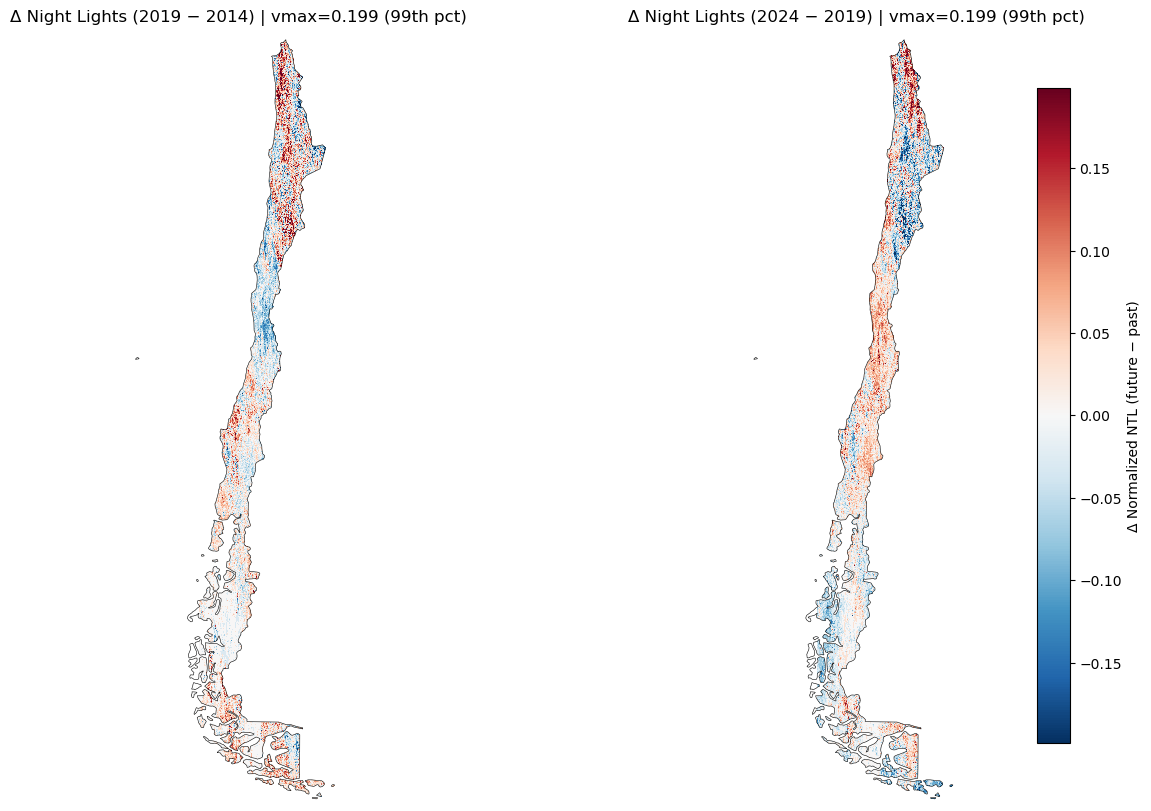

In [24]:
# Δ maps (divergent colormap, shared robust scale)

fig, axes = plt.subplots(1, 2, figsize=(14, 8), constrained_layout=True)

im1 = delta_19_14.plot.imshow(
    ax=axes[0],
    cmap="RdBu_r",
    vmin=-vmax,
    vmax=vmax,
    add_colorbar=False
)
chile.boundary.plot(ax=axes[0], edgecolor="black", linewidth=0.4)
axes[0].set_title(f"Δ Night Lights (2019 − 2014) | vmax={vmax:.3f} (99th pct)")
axes[0].set_xlim(-80, -65)
axes[0].set_ylim(-56, -17)
axes[0].set_axis_off()

im2 = delta_24_19.plot.imshow(
    ax=axes[1],
    cmap="RdBu_r",
    vmin=-vmax,
    vmax=vmax,
    add_colorbar=False
)
chile.boundary.plot(ax=axes[1], edgecolor="black", linewidth=0.4)
axes[1].set_title(f"Δ Night Lights (2024 − 2019) | vmax={vmax:.3f} (99th pct)")
axes[1].set_xlim(-80, -65)
axes[1].set_ylim(-56, -17)
axes[1].set_axis_off()

cbar = fig.colorbar(im2, ax=axes.ravel().tolist(), shrink=0.85)
cbar.set_label("Δ Normalized NTL (future − past)")

plt.show()

**Note: Red indicates relative increases in normalized night-time lights; blue indicates decreases. Color scale is symmetric and clipped at the 99th percentile of |Δ|.**

### **Observations from Δ maps (normalized night-time lights)**

The **2019–2014** delta map reveals a more **spatially structured pattern of change**, characterized by coherent clusters of positive values (relative increases in normalized night-time light intensity). These clusters are predominantly located around **major urban centers and longitudinal corridors**, suggesting localized intensification of night-time activity rather than uniform change across the territory. Negative changes are present but appear more scattered and less spatially dominant.

In contrast, the **2024–2019** delta map displays a more **heterogeneous and fragmented spatial pattern**, with positive and negative changes interspersed across the country and fewer clearly defined clusters. The visual balance between increases and decreases, combined with the absence of large contiguous areas of change, indicates a period of relative stabilization, where localized gains and losses largely offset each other at the national scale.

Importantly, both maps are displayed using a **shared, robust color scale** (symmetric and clipped at the 99th percentile of |Δ|), ensuring that differences in visual patterns reflect genuine spatial contrasts rather than differences in scaling. These observations are consistent with the subsequent descriptive statistics, which show a small positive mean change for 2019–2014 and an almost neutral mean for 2024–2019.

### Descriptive statistics of Δ

In [25]:
def summarize_delta(delta, label):
    arr = delta.values
    arr = arr[np.isfinite(arr)]
    print(f"\n{label}")
    print(f"Mean   : {arr.mean():.4f}")
    print(f"Median : {np.median(arr):.4f}")
    print(f"Std    : {arr.std():.4f}")
    print(f"Min    : {arr.min():.4f}")
    print(f"Max    : {arr.max():.4f}")

summarize_delta(delta_19_14, "Δ 2019−2014")
summarize_delta(delta_24_19, "Δ 2024−2019")


Δ 2019−2014
Mean   : 0.0069
Median : 0.0000
Std    : 0.0627
Min    : -0.4326
Max    : 0.5040

Δ 2024−2019
Mean   : 0.0001
Median : 0.0000
Std    : 0.0647
Min    : -0.5478
Max    : 0.5237


The descriptive statistics confirm the visual patterns observed in the delta maps. 

The 2019–2014 period exhibits a small but positive mean change, indicating a slight net increase in normalized nighttime light intensity, while the 2024–2019 period shows an almost neutral mean, suggesting overall stabilization. 

In both periods, medians close to zero and comparable standard deviations indicate that most pixel-level changes are minor, with a limited number of localized hotspots driving the observed extremes.

### Histograms of Δ (log-scaled frequency)

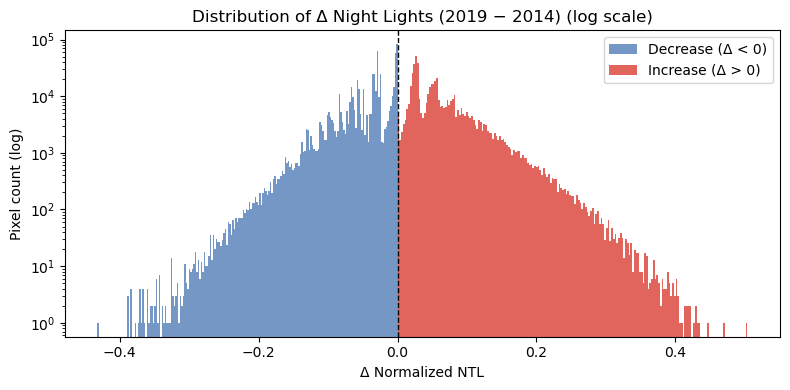

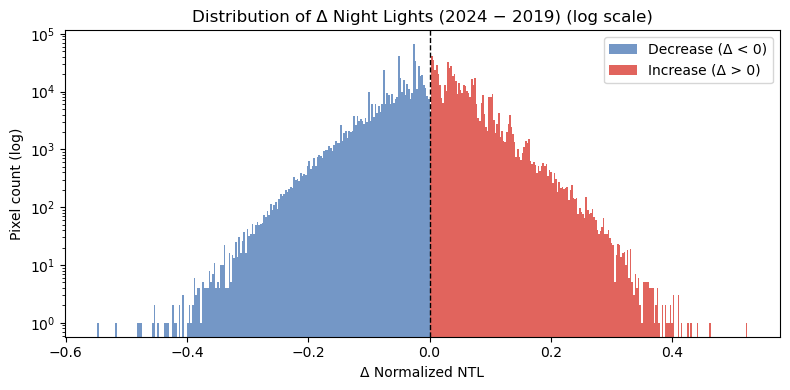

In [26]:
def plot_hist_log_colored(delta, title):
    arr = delta.values.flatten()
    arr = arr[np.isfinite(arr)]

    neg = arr[arr < 0]
    pos = arr[arr > 0]

    plt.figure(figsize=(8, 4))

    plt.hist(
        neg,
        bins=200,
        color="#4575b4",   # azul
        alpha=0.75,
        label="Decrease (Δ < 0)"
    )
    plt.hist(
        pos,
        bins=200,
        color="#d73027",   # rojo
        alpha=0.75,
        label="Increase (Δ > 0)"
    )

    plt.axvline(0, color="black", linestyle="--", linewidth=1)
    plt.yscale("log")

    plt.title(title + " (log scale)")
    plt.xlabel("Δ Normalized NTL")
    plt.ylabel("Pixel count (log)")
    plt.legend()
    plt.tight_layout()
    plt.show()

plot_hist_log_colored(delta_19_14, "Distribution of Δ Night Lights (2019 − 2014)")
plot_hist_log_colored(delta_24_19, "Distribution of Δ Night Lights (2024 − 2019)")

The colored histograms emphasize the balance between negative (blue) and positive (red) pixel-level changes. 

While both periods are dominated by small-magnitude variations concentrated around zero, the 2019–2014 distribution exhibits a slightly heavier positive tail, whereas the 2024–2019 distribution shows a more symmetric pattern between increases and decreases.

### Summary of change detection results

The change detection analysis reveals that night-time light variations in Chile are generally subtle at the national scale, with most pixel-level changes concentrated around zero.

For the 2019–2014 period, the slightly positive mean (Δ ≈ +0.007) indicates a small net increase in night-time activity. This signal is spatially heterogeneous, as shown in the Δ map, where localized clusters of increase coexist with areas of decline. The histogram confirms this pattern by showing a mild right-skew, driven by a limited number of positive outliers.

In contrast, the 2024–2019 period exhibits a mean change very close to zero (Δ ≈ +0.0001), suggesting an overall stabilization of night-time light intensity. Both the Δ map and the histogram display a more symmetric distribution of positive and negative changes, indicating that increases and decreases largely balance out at the national level.

In both periods, median values near zero and standard deviations around 0.06 highlight that most of the territory experiences only minor variations, while the observed extrema (approximately ±0.5) reflect localized hotspots of significant change rather than widespread national trends.

<a id="categorical-change-maps"></a>
## 9. Categorical change maps

### What
Convert deltas into categorical classes:
- **Increase**
- **Decrease**
- **Stable**

### Why
Categories make interpretation easier than raw delta values, especially for communication in a portfolio.

### How
- Choose thresholds (explicitly stated)
- Classify raster
- Export categorical rasters
- Plot categorical maps with legend

### Classify deltas into categorical change classes (± threshold)

In [29]:
# Categorical classification (increase / stable / decrease)

TH = 0.03  # threshold; later you can test 0.02 or 0.05

def classify_change(delta, th=TH):
    return xr.where(delta > th, 1, xr.where(delta < -th, -1, 0))

cat_19_14 = classify_change(delta_19_14)
cat_24_19 = classify_change(delta_24_19)

cat_dir = PROC_DIR / "categories"
cat_dir.mkdir(parents=True, exist_ok=True)

cat_paths = {
    "2019_2014": cat_dir / "cat_2019_2014.tif",
    "2024_2019": cat_dir / "cat_2024_2019.tif",
}

cat_19_14.rio.to_raster(cat_paths["2019_2014"], dtype="int8")
cat_24_19.rio.to_raster(cat_paths["2024_2019"], dtype="int8")

print("Saved:", cat_paths)

Saved: {'2019_2014': WindowsPath('C:/Users/crgal/Desktop/Github/chile-night-lights-change/data/processed/categories/cat_2019_2014.tif'), '2024_2019': WindowsPath('C:/Users/crgal/Desktop/Github/chile-night-lights-change/data/processed/categories/cat_2024_2019.tif')}


### Categorical change maps (discrete classes)

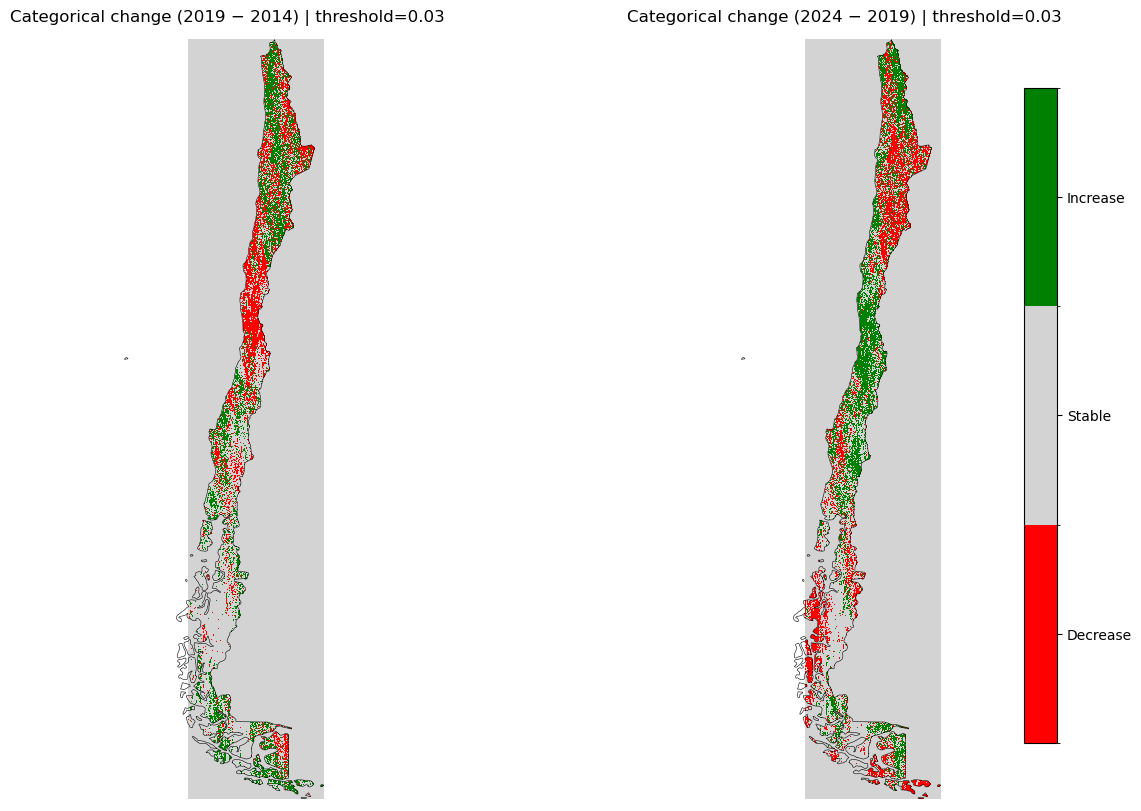

In [36]:
cmap = ListedColormap(["red", "lightgray", "green"])  # decrease, stable, increase
norm = BoundaryNorm([-1.5, -0.5, 0.5, 1.5], cmap.N)

fig, axes = plt.subplots(1, 2, figsize=(14, 8), constrained_layout=True)

im1 = cat_19_14.plot.imshow(ax=axes[0], cmap=cmap, norm=norm, add_colorbar=False)
chile.boundary.plot(ax=axes[0], edgecolor="black", linewidth=0.4)
axes[0].set_title(f"Categorical change (2019 − 2014) | threshold={TH}")
axes[0].set_xlim(-80, -65); axes[0].set_ylim(-56, -17)
axes[0].set_axis_off()

im2 = cat_24_19.plot.imshow(ax=axes[1], cmap=cmap, norm=norm, add_colorbar=False)
chile.boundary.plot(ax=axes[1], edgecolor="black", linewidth=0.4)
axes[1].set_title(f"Categorical change (2024 − 2019) | threshold={TH}")
axes[1].set_xlim(-80, -65); axes[1].set_ylim(-56, -17)
axes[1].set_axis_off()

cbar = fig.colorbar(im2, ax=axes.ravel().tolist(), ticks=[-1, 0, 1], shrink=0.85)
cbar.ax.set_yticklabels(["Decrease", "Stable", "Increase"])

plt.show()

Note: Pixels are classified as **Increase** (Δ > +0.03), **Decrease** (Δ < −0.03), or **Stable** (|Δ| ≤ 0.03), providing an interpretable summary of localized changes while reducing sensitivity to very small fluctuations around zero.

### Interpretation of categorical change maps

The categorical change maps provide a simplified and intuitive view of nighttime light dynamics by separating the signal into areas of **increase**, **decrease**, and **stability**, based on a fixed threshold (±0.03 in normalized units).

For the **2019–2014** period, the spatial pattern is characterized by a mosaic of increases and decreases distributed across the country, with no single dominant trend at the national scale. This indicates a phase of **heterogeneous change**, where localized growth in nighttime activity coexists with areas of decline. Such patterns are consistent with region-specific or sector-driven processes rather than a uniform nationwide expansion.

In contrast, the **2024–2019** categorical map shows a noticeably larger proportion of **stable** pixels, with fewer areas classified as strong increases or decreases. This suggests a relative stabilization of nighttime light activity in recent years, in agreement with the near-zero mean change observed in the continuous delta analysis.

Overall, these categorical representations confirm that changes in nighttime lights across Chile are **highly localized in space**. While significant increases and decreases do occur, they are not spatially continuous at the national scale, reinforcing the need for **regional-level aggregation and analysis** to better understand the underlying drivers of change.

<a id="regional-aggregation"></a>
## 10. Regional aggregation and metrics

### What
Aggregate delta and categorical change by Chilean regions.

### Outputs
- Mean delta by region
- % pixels: increase/decrease/stable
- Ranking tables (top increases/decreases)

### How
- Clip by each region geometry
- Compute metrics
- Save CSV tables

### Download Regions of Chile (Admin-1) with GADM

In [37]:
# Prepare directory for administrative boundaries (raw)

boundaries_dir = RAW_DIR / "boundaries"
boundaries_dir.mkdir(parents=True, exist_ok=True)

boundaries_dir

WindowsPath('C:/Users/crgal/Desktop/Github/chile-night-lights-change/data/raw/boundaries')

In [38]:
# Download GADM boundaries for Chile (GPKG)

gadm_url = "https://geodata.ucdavis.edu/gadm/gadm4.1/gpkg/gadm41_CHL.gpkg"
gadm_local = boundaries_dir / "gadm41_CHL.gpkg"

if not gadm_local.exists():
    try:
        urllib.request.urlretrieve(gadm_url, gadm_local)
        print("Downloaded:", gadm_local)
    except Exception as e:
        raise RuntimeError(f"Failed to download GADM: {e}")
else:
    print("Already exists:", gadm_local)

Already exists: C:\Users\crgal\Desktop\Github\chile-night-lights-change\data\raw\boundaries\gadm41_CHL.gpkg


In [39]:
# Inspect available layers in the GADM GeoPackage

layers = fiona.listlayers(gadm_local)
layers

['ADM_ADM_0', 'ADM_ADM_1', 'ADM_ADM_2', 'ADM_ADM_3']

In [40]:
# Load Admin-1 regions (GADM level 1) and set CRS to WGS84

layer_level1 = "ADM_ADM_1"  # <- this is the correct layer name

gadm1 = gpd.read_file(gadm_local, layer=layer_level1).to_crs("EPSG:4326")

# Inspect columns to find the region name field
print("Columns:", list(gadm1.columns))

gadm1.head()

Columns: ['GID_1', 'GID_0', 'COUNTRY', 'NAME_1', 'VARNAME_1', 'NL_NAME_1', 'TYPE_1', 'ENGTYPE_1', 'CC_1', 'HASC_1', 'ISO_1', 'geometry']


,GID_1,GID_0,COUNTRY,NAME_1,VARNAME_1,NL_NAME_1,TYPE_1,ENGTYPE_1,CC_1,HASC_1,ISO_1,geometry
0,CHL.2_1,CHL,Chile,Antofagasta,NA,NA,Región,Region,II,CL.AN,CL-AN,"MULTIPOLYGON (((-70.69986 -25.89208, -70.69984..."
1,CHL.3_1,CHL,Chile,Araucanía,Araucanie|La Araucanía,NA,Región,Region,IX,CL.AR,NA,"MULTIPOLYGON (((-71.43538 -38.98652, -71.43437..."
2,CHL.4_1,CHL,Chile,Arica y Parinacota,NA,NA,Región,Region,XV,CL.AP,CL-AP,"MULTIPOLYGON (((-69.28189 -17.96854, -69.28175..."
3,CHL.5_1,CHL,Chile,Atacama,NA,NA,Región,Region,III,CL.AT,CL-AT,"MULTIPOLYGON (((-71.26113 -28.49285, -71.26112..."
4,CHL.1_1,CHL,Chile,Aysén del General Ibañez del Cam,Aisén|Aysén|Aisén del General Ca,NA,Región,Region,XI,CL.AI,NA,"MULTIPOLYGON (((-75.57556 -48.75867, -75.57551..."


### Selecting a robust region name field

Administrative boundary datasets may expose multiple name-related attributes (e.g. official names, alternative spellings, language-specific variants).  
To ensure that the regional aggregation remains **robust and reproducible**, we do not hardcode a single column name.

Instead, we:
- inspect all available attributes containing the keyword *"name"*, and
- select the most appropriate field following a predefined priority order.

This approach allows the workflow to remain stable even if the boundary source or schema changes, while still producing a clean and interpretable regional identifier for downstream analysis.

In [41]:
# Identify candidate fields for region names

name_candidates = [c for c in gadm1.columns if "name" in c.lower()]
print("Name candidates:", name_candidates)

Name candidates: ['NAME_1', 'VARNAME_1', 'NL_NAME_1']


In [42]:
# Choose best region name field (robust) and export clean Admin-1 layer

preferred = ["NAME_1", "NAME", "NAME_EN", "NAME_ES"]
name_field = next((c for c in preferred if c in gadm1.columns), None)

if name_field is None:
    # Fallback: take the first column containing "name"
    name_field = next((c for c in gadm1.columns if "name" in c.lower()), None)

if name_field is None:
    raise ValueError("No region name column found in GADM Admin-1 layer.")

# Build clean regions GeoDataFrame
regions = gadm1[[name_field, "geometry"]].rename(columns={name_field: "region"}).copy()

# Basic text cleanup
regions["region"] = regions["region"].astype(str).str.strip()

# Validate expected structure
assert regions["region"].notna().all(), "Some regions have missing names."
assert regions.shape[0] == 16, f"Expected 16 regions for Chile, got {regions.shape[0]}."

# Export to processed GeoPackage for reuse
regions_path = PROC_DIR / "chile_regions_admin1.gpkg"
regions.to_file(regions_path, layer="regions", driver="GPKG")

print(f"Saved: {regions_path} | Regions: {regions.shape[0]} | Name field used: {name_field}")

regions.head()

Saved: C:\Users\crgal\Desktop\Github\chile-night-lights-change\data\processed\chile_regions_admin1.gpkg | Regions: 16 | Name field used: NAME_1


,region,geometry
0,Antofagasta,"MULTIPOLYGON (((-70.69986 -25.89208, -70.69984..."
1,Araucanía,"MULTIPOLYGON (((-71.43538 -38.98652, -71.43437..."
2,Arica y Parinacota,"MULTIPOLYGON (((-69.28189 -17.96854, -69.28175..."
3,Atacama,"MULTIPOLYGON (((-71.26113 -28.49285, -71.26112..."
4,Aysén del General Ibañez del Cam,"MULTIPOLYGON (((-75.57556 -48.75867, -75.57551..."


In [43]:
# Ensure categorical rasters have CRS (inherit from delta rasters)
cat_19_14 = cat_19_14.rio.write_crs(delta_19_14.rio.crs, inplace=False)
cat_24_19 = cat_24_19.rio.write_crs(delta_24_19.rio.crs, inplace=False)

print("CRS cat_19_14:", cat_19_14.rio.crs)
print("CRS cat_24_19:", cat_24_19.rio.crs)

CRS cat_19_14: EPSG:4326
CRS cat_24_19: EPSG:4326


### Computing regional change metrics

To move from pixel-level analysis to a regional perspective, we aggregate both the **continuous delta rasters** and the **categorical change maps** within each administrative region.

For every Chilean region (Admin-1), we compute:
- the **mean**, **median**, and **standard deviation** of the normalized delta values, and
- the **percentage of pixels** classified as *Increase*, *Decrease*, and *Stable*.

This is achieved by spatially clipping the delta and categorical rasters to each regional geometry and computing summary statistics on valid pixels only.  
The resulting tables provide a compact and comparable representation of night-time light dynamics across regions, enabling regional ranking and cross-period comparison.

In [44]:
# Compute regional metrics (mean Δ and % increase/decrease/stable)

regions_gdf = gpd.read_file(regions_path, layer="regions").to_crs("EPSG:4326")

def region_metrics(delta, cat, regions_gdf):
    rows = []
    for _, r in regions_gdf.iterrows():
        geom = [r.geometry]

        d_clip = delta.rio.clip(geom, regions_gdf.crs, drop=True)
        c_clip = cat.rio.clip(geom, regions_gdf.crs, drop=True)

        darr = d_clip.values
        carr = c_clip.values

        valid = np.isfinite(darr)
        if valid.sum() == 0:
            continue

        total = valid.sum()
        inc = np.sum((carr == 1) & valid)
        dec = np.sum((carr == -1) & valid)
        sta = np.sum((carr == 0) & valid)

        rows.append({
            "region": r["region"],
            "delta_mean": float(np.nanmean(darr)),
            "delta_median": float(np.nanmedian(darr)),
            "delta_std": float(np.nanstd(darr)),
            "pct_increase": inc / total * 100,
            "pct_decrease": dec / total * 100,
            "pct_stable": sta / total * 100,
        })

    return pd.DataFrame(rows).sort_values("delta_mean", ascending=False)

df_19_14 = region_metrics(delta_19_14, cat_19_14, regions_gdf)
df_24_19 = region_metrics(delta_24_19, cat_24_19, regions_gdf)

df_19_14.head(10), df_24_19.head(10)

(                              region  delta_mean  delta_median  delta_std  \
 2                 Arica y Parinacota    0.041813      0.037409   0.088141   
 14                          Tarapacá    0.026473      0.022281   0.102083   
 12                             Ñuble    0.026459      0.025478   0.049612   
 5                            Bío-Bío    0.020991      0.022038   0.054816   
 10    Magallanes y Antártica Chilena    0.018669      0.000000   0.048183   
 8                          Los Lagos    0.013759      0.020835   0.040449   
 0                        Antofagasta    0.009561      0.009938   0.082315   
 3                            Atacama    0.008918     -0.001610   0.084282   
 11                             Maule    0.004706     -0.002557   0.052235   
 7   Libertador General Bernardo O'Hi    0.001053     -0.002204   0.044827   
 
     pct_increase  pct_decrease  pct_stable  
 2      53.564556     20.849370   25.586074  
 14     46.512880     29.009963   24.477156  
 1

### Regional results (sanity check and interpretation)

**2019–2014 (top regions by mean Δ)**  
The ranking is led by **Arica y Parinacota** (mean Δ ≈ **0.042**), followed by **Tarapacá** and **Ñuble**.  
Top-ranked regions combine (i) a positive mean Δ and (ii) a relatively high proportion of pixels classified as *Increase*, suggesting localized intensification of night-time light activity during this period.

**2024–2019 (top regions by mean Δ)**  
**Arica y Parinacota** remains the top region (mean Δ ≈ **0.052**). **Valparaíso** and the **Metropolitan Region** also show strong positive mean Δ, with high *Increase* shares (e.g., >60% in some regions).  
Compared to 2019–2014, the distribution of positive changes appears more widespread across multiple regions.

**Note on interpretation:** These results quantify changes in *normalized night-time radiance* and are internally consistent with the categorical change maps. Explaining causal drivers (e.g., economic activity, infrastructure) would require additional external datasets and domain-specific validation.

### Export regional metrics tables to CSV

In [45]:
tables_dir = PROC_DIR / "tables"
tables_dir.mkdir(parents=True, exist_ok=True)

df_19_14.to_csv(tables_dir / "region_metrics_2019_2014.csv", index=False)
df_24_19.to_csv(tables_dir / "region_metrics_2024_2019.csv", index=False)

print("Saved CSVs in:", tables_dir)

Saved CSVs in: C:\Users\crgal\Desktop\Github\chile-night-lights-change\data\processed\tables


# <a id="results-and-interpretation"></a>
## 11. Results and interpretation

### Overall summary

This analysis quantified changes in night-time light (NTL) intensity across Chile for two periods: **2014–2019** and **2019–2024**, using annual mean composites derived from VIIRS Black Marble data.

At the national scale, results indicate:
- a **slight positive net increase** in normalized NTL between **2014 and 2019**, and
- an **almost neutral net change** between **2019 and 2024**, despite the presence of strong localized variations.

Spatially, changes are **highly heterogeneous**, with increases and decreases concentrated in specific regions rather than forming a uniform national pattern. This highlights the importance of regional-level aggregation to interpret night-time light dynamics meaningfully.

---

### Spatial and regional patterns

#### Pixel-level patterns
Continuous delta maps and categorical change maps reveal that:
- most pixels exhibit **small changes close to zero**, and
- large positive or negative changes are **spatially localized**, forming distinct hotspots.

Between **2014 and 2019**, the spatial signal is characterized by a mosaic of increases and decreases, indicating heterogeneous development trajectories across the country.

Between **2019 and 2024**, a larger proportion of pixels are classified as *stable*, suggesting a phase of relative stabilization in night-time light activity following earlier changes.

#### Regional aggregation
Regional metrics provide a clearer and more interpretable picture of these patterns:

- **Arica y Parinacota** consistently ranks among the regions with the highest mean increases in both periods.
- During **2014–2019**, positive mean changes are primarily concentrated in northern regions (e.g. Arica y Parinacota, Tarapacá), while many central and southern regions show mixed signals of growth and stability.
- During **2019–2024**, positive changes become more widespread, with strong increases observed not only in northern regions but also in **Valparaíso** and the **Metropolitan Region**, accompanied by high proportions of pixels classified as *Increase*.

These results indicate that while overall national averages remain modest, **regional contrasts are substantial**.

---

### Temporal interpretation (2014→2019 vs 2019→2024)

The two analyzed periods exhibit distinct characteristics:

- **2014–2019**  
  This period shows moderate but spatially heterogeneous growth in night-time lights. The coexistence of increases and decreases across regions suggests that changes were driven by localized processes rather than by a synchronized national trend.

- **2019–2024**  
  In contrast, this period is marked by near-zero net change at the national level but a higher degree of regional differentiation. Several regions display strong localized increases alongside large stable areas, consistent with a phase of recovery and consolidation rather than rapid nationwide expansion.

Importantly, the near-zero national mean does **not** imply the absence of change, but rather that **positive and negative regional signals offset each other** when aggregated.

---

### Interpretation and caveats

Night-time lights are widely used as a proxy for human activity, urbanization, and infrastructure presence. In this context, the observed patterns are **consistent with plausible mechanisms** such as:
- uneven urban expansion,
- infrastructure development concentrated in specific regions, and
- temporal disruptions followed by partial recovery during the later period.

However, it is important to emphasize that:
- NTL changes measure **radiance variation**, not economic output directly;
- causal attribution (e.g. to specific policies or sectors) cannot be established without integrating external socioeconomic data.

Therefore, the results should be interpreted as **spatial indicators of relative change**, rather than as direct measures of economic growth.

---

### General conclusion

This study demonstrates that VIIRS night-time light data can effectively capture **spatially explicit patterns of change** in human activity across Chile over the last decade.

While national-level averages suggest modest overall change, regional analysis reveals pronounced heterogeneity, underscoring the value of combining pixel-level analysis with regional aggregation.  
These findings provide a solid foundation for future work integrating additional datasets to further investigate the drivers and implications of nighttime light dynamics in Chile.

# <a id="limitations-and-next-steps"></a>
## 12. Limitations and next steps

### Limitations

Despite the robustness of the processing pipeline and the internal consistency of the results, several limitations should be acknowledged:

- **Proxy nature of night-time lights**  
  Night-time light intensity is an indirect proxy for human activity and infrastructure. Changes in radiance do not translate one-to-one into economic growth, population change, or development intensity.

- **Normalization effects**  
  Min–Max normalization is applied independently per year to enable visual comparability. While this approach is appropriate for spatial pattern analysis, it removes information about absolute radiance differences across years and may dampen large-scale temporal contrasts.

- **Threshold sensitivity in categorical maps**  
  The choice of a fixed threshold (±0.03) for classifying increase, decrease, and stability is heuristic. Different thresholds may alter the proportion of pixels assigned to each class, particularly near zero-change regions.

- **Temporal aggregation**  
  Annual mean composites smooth short-term variability and seasonal effects. As a result, transient events or short-lived changes in night-time activity are not explicitly captured.

- **Georeferencing assumptions**  
  The BBox-based fallback georeferencing strategy ensures spatial consistency but may introduce minor spatial uncertainty when compared to fully geolocated products.

---

### Next steps

To extend and strengthen this analysis, several directions are recommended:

- **Sensitivity analysis**  
  Evaluate the robustness of results by testing alternative normalization strategies (e.g. global normalization across years) and different categorical thresholds.

- **Integration of external datasets**  
  Combine night-time light data with socioeconomic indicators such as population density, census data, GDP proxies, or land-use maps to better contextualize observed changes.

- **Higher temporal resolution**  
  Analyze monthly or seasonal composites to explore short-term dynamics, including responses to specific events or policy interventions.

- **Advanced spatial analysis**  
  Apply spatial clustering or hotspot detection techniques to formally identify statistically significant regions of change.

- **Cross-country or subnational comparison**  
  Extend the workflow to other countries or to finer administrative levels (e.g. municipalities) to assess the generalizability of the approach.

---

### General outlook

Overall, this project establishes a reproducible and extensible framework for analyzing night-time light dynamics at the national and regional scale. By addressing the identified limitations and incorporating richer contextual data, future work can further enhance the interpretability and policy relevance of night-time light-based analyses.

# <a id="credits-and-technologies"></a>
## 13. Credits and technologies

### Authorship
**Author:** Cristián Andrés Galleguillos Vega  
**Role:** Data Scientist | Biologist |  
MSc in Data Science & Big Data | MSc in Natural Resources Engineering  

**Repository:** GitHub – Chile Night Lights Change (update link once published)

This project was developed as part of a professional portfolio consolidation process in **Data Science applied to geospatial analysis and remote sensing**.  
It combines quantitative data processing, spatial analytics, and scientific interpretation to analyze large-scale patterns of human activity using satellite-derived night-time light data.

---

### Data Sources
- **VIIRS Black Marble (VNP46A3)**  
  Annual night-time light composites provided by NASA Earthdata, used as a proxy for human activity, urbanization, and economic dynamics.

- **GADM – Global Administrative Areas (v4.1)**  
  Administrative boundaries of Chile (Admin-1 level), used for regional aggregation and spatial analysis.

---

### Main Technologies and Libraries

| Category | Tools |
|--------|------|
| Programming language | Python 3.11 |
| Numerical computing | numpy |
| Data analysis & manipulation | pandas |
| Raster processing | xarray, rioxarray, rasterio |
| Vector geospatial analysis | geopandas, fiona |
| Visualization | matplotlib |
| Environment management | Anaconda, Jupyter Notebook |
| Version control | Git & GitHub |

# <a id="project-structure"></a>
## 14. Project structure

This repository follows a modular and reproducible structure that separates **source code**, **notebooks**, **raw inputs**, and **processed outputs**.

### Repository overview

chile-night-lights-change/<br>
├── data/<br>
│   ├── raw/<br>
│   │   ├── blackmarble/               # Raw VIIRS Black Marble HDF5 granules (by year)<br>
│   │   └── boundaries/                # Raw administrative boundaries (GADM)<br>
│   ├── interim/                       # (Reserved) intermediate artifacts (optional)<br>
│   └── processed/                     # Final pipeline outputs used for analysis/results<br>
│       ├── rasters/                   # Annual mean composites (raw GeoTIFF)<br>
│       ├── rasters_georef/            # Georeferenced rasters (WGS84 fallback)<br>
│       ├── rasters_clipped/           # Chile-clipped rasters (boundary mask)<br>
│       ├── rasters_norm/              # Min–Max normalized rasters (0–1 per year)<br>
│       ├── deltas/                    # Continuous change maps (Δ 2019–2014, Δ 2024–2019)<br>
│       ├── categories/                # Categorical change rasters (increase/stable/decrease)<br>
│       ├── tables/                    # Regional metrics CSV outputs<br>
│       ├── chile_boundary.gpkg        # Chile national boundary used for clipping/validation<br>
│       └── chile_regions_admin1.gpkg  # Admin-1 regions used for regional aggregation<br>
├── notebooks/<br>
│   └── 01_chile_night_lights_change.ipynb   # Main end-to-end analysis notebook<br>
├── reports/<br>
│   ├── figures/                       # (Optional) exported figures for README/report<br>
│   └── results/                       # (Optional) exported result summaries<br>
├── src/                               <br>
│   ├── config.py                      # Global parameters (YEARS, BBOX_CHILE, paths)<br>
│   ├── download.py                    # Earthaccess login + VNP46A3 download helpers<br>
│   ├── blackmarble.py                 # Annual mean composite generation from HDF5<br>
│   ├── geoprocessing.py               # Georeferencing, clipping, raster operations<br>
│   ├── geo_utils.py                   # Normalization and small raster utilities<br>
│   ├── boundaries.py                  # Boundary loading utilities (Chile / regions)<br>
│   └── utils.py                       # Notebook setup helpers (warnings, repo root, etc.)<br>
├── environment.yml                     # Reproducible conda environment<br>
└── readme.md                           # Project overview and usage instructions<br>

### Design rationale

- **`src/` contains all reusable logic**, keeping the notebook focused on the analytical narrative rather than implementation details.
- **`data/raw/` stores immutable inputs** (satellite granules + boundaries), ensuring traceability and re-runnability.
- **`data/processed/` stores derived outputs** at each major pipeline stage (annual composites → georef → clipped → normalized → deltas → categories → regional tables).
- **`notebooks/` contains the main reproducible workflow**, documented step-by-step for portfolio readability.

### Notes (maintenance)

- `data/interim/` and `reports/` are currently empty placeholders — they are optional, but useful if you later export publication-ready figures or summaries.
- The `__pycache__/` folder under `src/` is generated automatically by Python and does not affect the project logic.

# <a id="final-reflection"></a>
## 15. Final reflection

This project demonstrates how **satellite-derived night-time lights** can be effectively used as a quantitative proxy to explore large-scale patterns of human activity, urbanization, and territorial dynamics.

By constructing annual composites from raw VIIRS Black Marble data, applying consistent normalization, and performing both continuous and categorical change detection, the analysis moves beyond visualization toward **interpretable spatial insights**. The regional aggregation further illustrates how national-scale trends often mask strong **subnational heterogeneity**, reinforcing the importance of spatially explicit analysis.

From a Data Science perspective, this work highlights the value of:
- reproducible pipelines,  
- modular code design, and  
- transparent methodological decisions,  

especially when working with complex geospatial and remote sensing datasets.

From an environmental and territorial standpoint, the results underline that changes in night-time light intensity are **highly localized**, reflecting diverse regional drivers such as urban growth, infrastructure development, economic activity, and post-pandemic recovery processes.

Overall, this project reinforces the role of **interdisciplinary Data Science** as a bridge between satellite observations and real-world decision-making. The workflow presented here can be extended to other countries, longer time series, or combined with socioeconomic and environmental indicators, opening the door to broader applications in urban studies, sustainability assessment, and spatial policy analysis.